# Draper Addition circuit with artificial random noise 

In [11]:
import numpy as np
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit import Gate
from qiskit.circuit.library import CXGate, CYGate, CZGate
import qiskit.quantum_info as qi

### QFT and IQFT

In [12]:
def qft(circuit,n):
    n = circuit.num_qubits
    for i in range(n):
        circuit.h(i)
        for j in range(i + 1, n):
            circuit.cp(np.pi / 2**(j - i), j, i)
        #circuit.barrier()
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)
    return circuit

def iqft(circuit,n):
    n = circuit.num_qubits
    circuit = qft(circuit,n)
    return circuit.inverse()

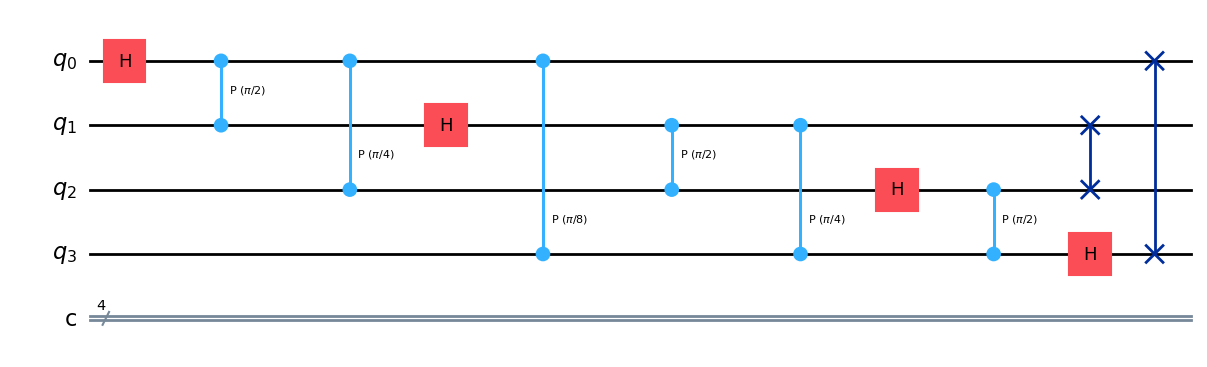

In [13]:
hello = qft(QuantumCircuit(4,4),QuantumCircuit(4,4).num_qubits)
hello.draw('mpl')

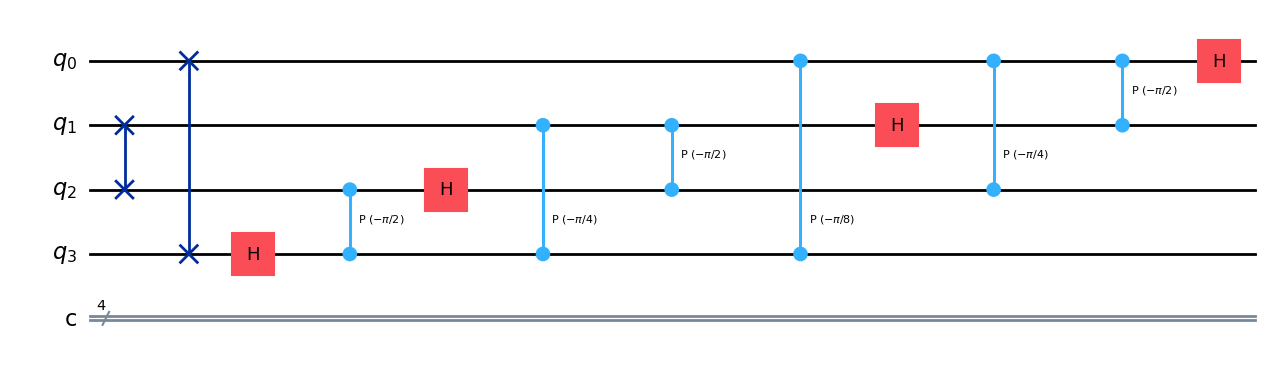

In [14]:
bye = iqft(QuantumCircuit(4,4),QuantumCircuit(4,4).num_qubits)
bye.draw('mpl')

# Start of TASK 2

From here we build the Draper function and then check for the validity of the results and subsequently introduce noise and see how the noise affects our statevector and gives wrong results and the extent of such effects. 

# DRAPER FUNCTION

In [15]:
n=3
circuit = QuantumCircuit(n*2, n)
qft_op = QuantumCircuit(n)
qft_op = qft(qft_op,n)
qft_op.to_gate()
circuit.append(qft_op,list(range(n,2*n)))
circuit.decompose().draw()

q_0: ─────────────────────────────────────────────
                                                  
q_1: ─────────────────────────────────────────────
                                                  
q_2: ─────────────────────────────────────────────
     ┌───┐                                        
q_3: ┤ H ├─■─────────────■──────────────────────X─
     └───┘ │P(π/2) ┌───┐ │                      │ 
q_4: ──────■───────┤ H ├─┼────────■─────────────┼─
                   └───┘ │P(π/4)  │P(π/2) ┌───┐ │ 
q_5: ────────────────────■────────■───────┤ H ├─X─
                                          └───┘   
c: 3/═════════════════════════════════════════════

In [20]:
def quantum_sum(a, b, n):
    #n = max(len(format(a, 'b')), len(format(a, 'b')))
    circuit = QuantumCircuit(n*2, n)
    #init the states
    for i in range(n):
        if (a >> i) & 1:
            circuit.x(n-i-1)
        if (b >> i) & 1:
            circuit.x(i + n)
    
    qft_op = QuantumCircuit(n,name="qft")
    qft_op = qft(qft_op,n)
    qft_op.to_gate()
    circuit.append(qft_op,list(range(n,2*n)))
    
    for i in range(n):
        #circuit.h(i)
        for j in range(i, n):
            circuit.cp(np.pi / 2**(j - i), i+n, j)
        #circuit.barrier()
    
    iqft_op = QuantumCircuit(n,name="iqft")
    iqft_op = iqft(iqft_op,n)
    iqft_op.to_gate()
    circuit.append(iqft_op,list(range(n,2*n)))
    #circuit.measure(range(n), range(n))
    return circuit#.inverse()

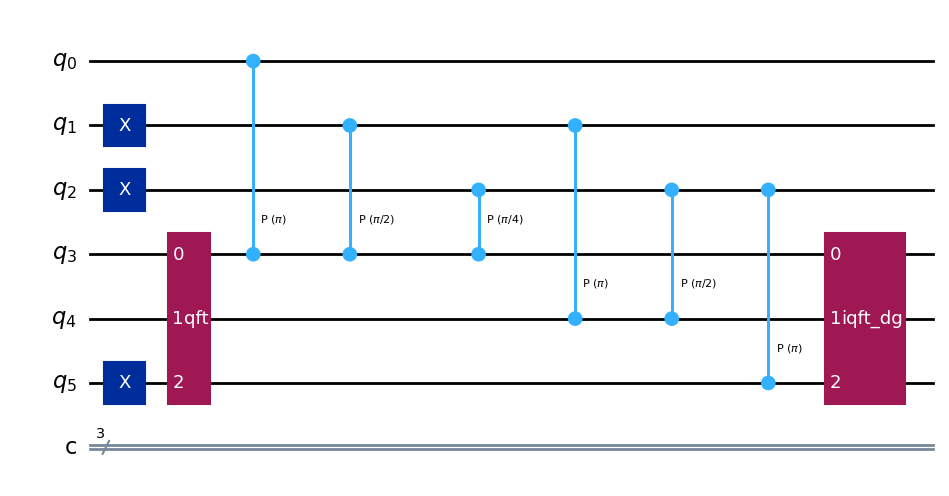

In [21]:
qc = quantum_sum(3, 4, 3)
qc.draw('mpl')

### Noise insertion using random pauli gates

In [22]:
# Pauli Gates as custom quantum operations
pauli_gates = {'X': Gate("x", 1, []), 'Y': Gate("y", 1, []), 'Z': Gate("z", 1, [])}
controlled_pauli_gates = {'CX': CXGate(), 'CY': CYGate(), 'CZ': CZGate()}

def add_noise(circuit, alpha, beta, n):
    noisy_circuit = QuantumCircuit(2*n, n)
    for instr, qargs, _ in circuit:
        noisy_circuit.append(instr, qargs)
        noise_prob = alpha if instr.num_qubits == 1 else beta
        if np.random.rand() < noise_prob and instr.num_qubits == 1:
            noise_gate = pauli_gates[np.random.choice(['X', 'Y', 'Z'])]
            noisy_circuit.append(noise_gate, [qargs[0]])
        elif instr.num_qubits == 2 and np.random.rand() < beta:
            noise_gate = controlled_pauli_gates[np.random.choice(['CX', 'CY', 'CZ'])]
            noisy_circuit.append(noise_gate, qargs)
    return noisy_circuit

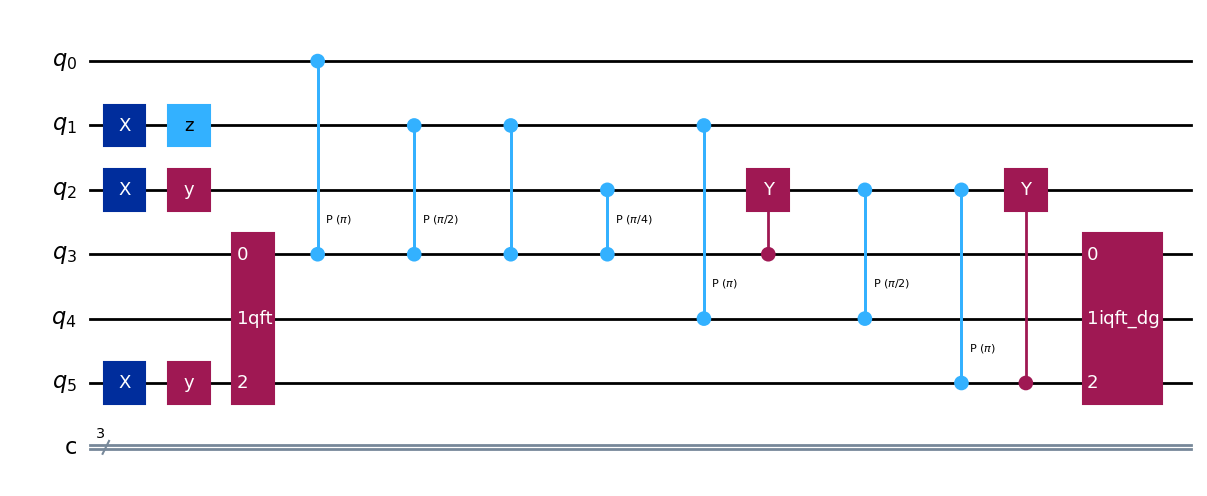

In [23]:
noisy_qc = add_noise(qc, alpha=0.9, beta=0.35, n=3)
noisy_qc.draw('mpl')

## Adding measurements

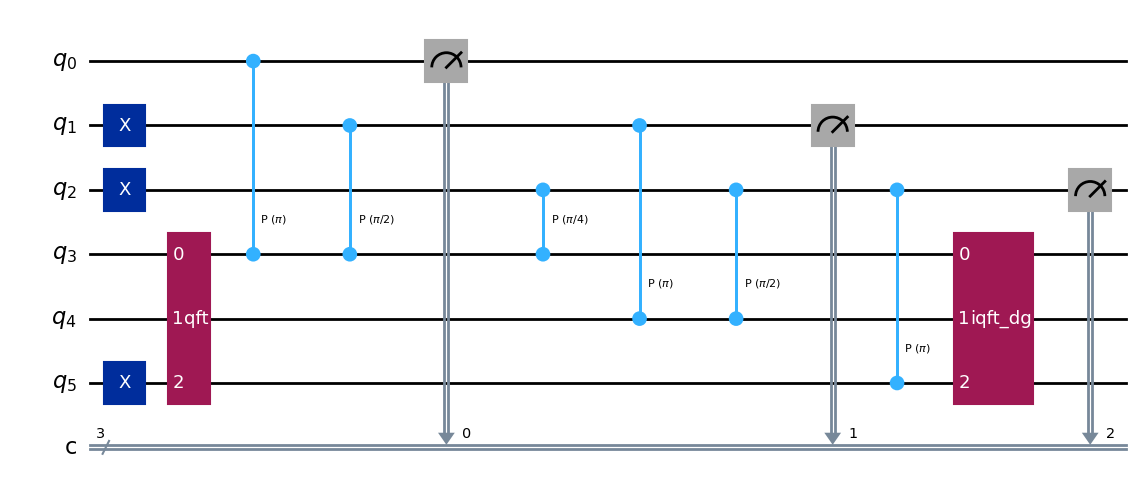

In [24]:
def add_meas(qc, noisy_qc,n):
    qc.measure(range(n), range(n))
    noisy_qc.measure(range(n), range(n))
    return qc, noisy_qc

qc, noisy_qc = add_meas(qc,noisy_qc,3)
qc.draw('mpl')

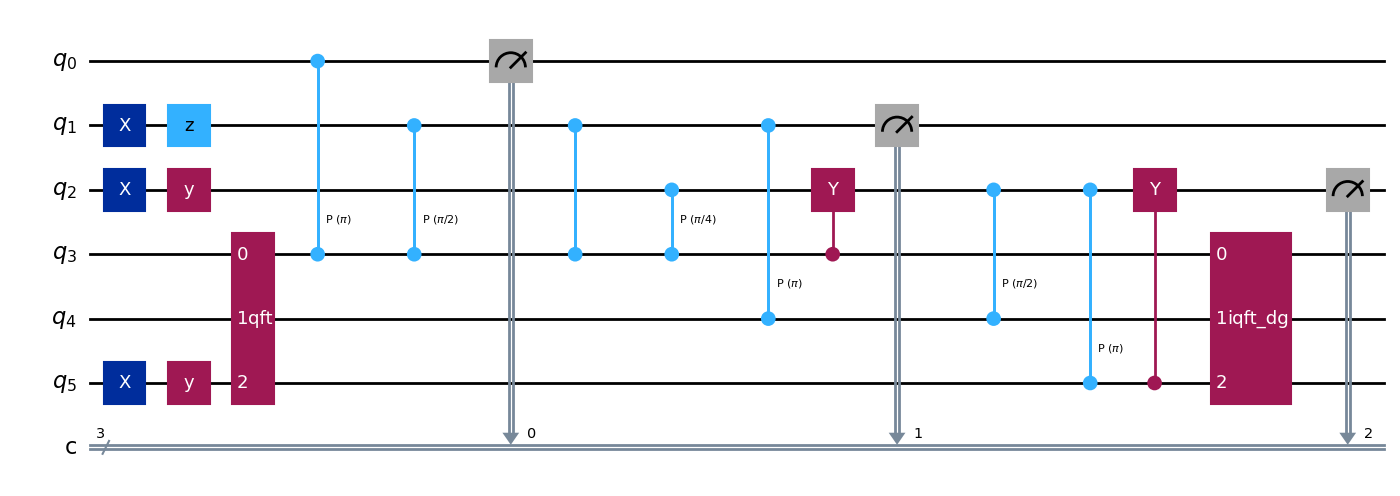

In [25]:
noisy_qc.draw('mpl')

# Simulation

In [26]:
from qiskit_aer import AerSimulator, StatevectorSimulator, Aer

sim = AerSimulator()
basis = ['cx', 'id', 'rz', 'sx', 'x']

ideal = transpile(qc, sim, basis_gates=basis)
nonideal = transpile(noisy_qc, sim, basis_gates=basis)

#ideal.measure_all()
#nonideal.measure_all()

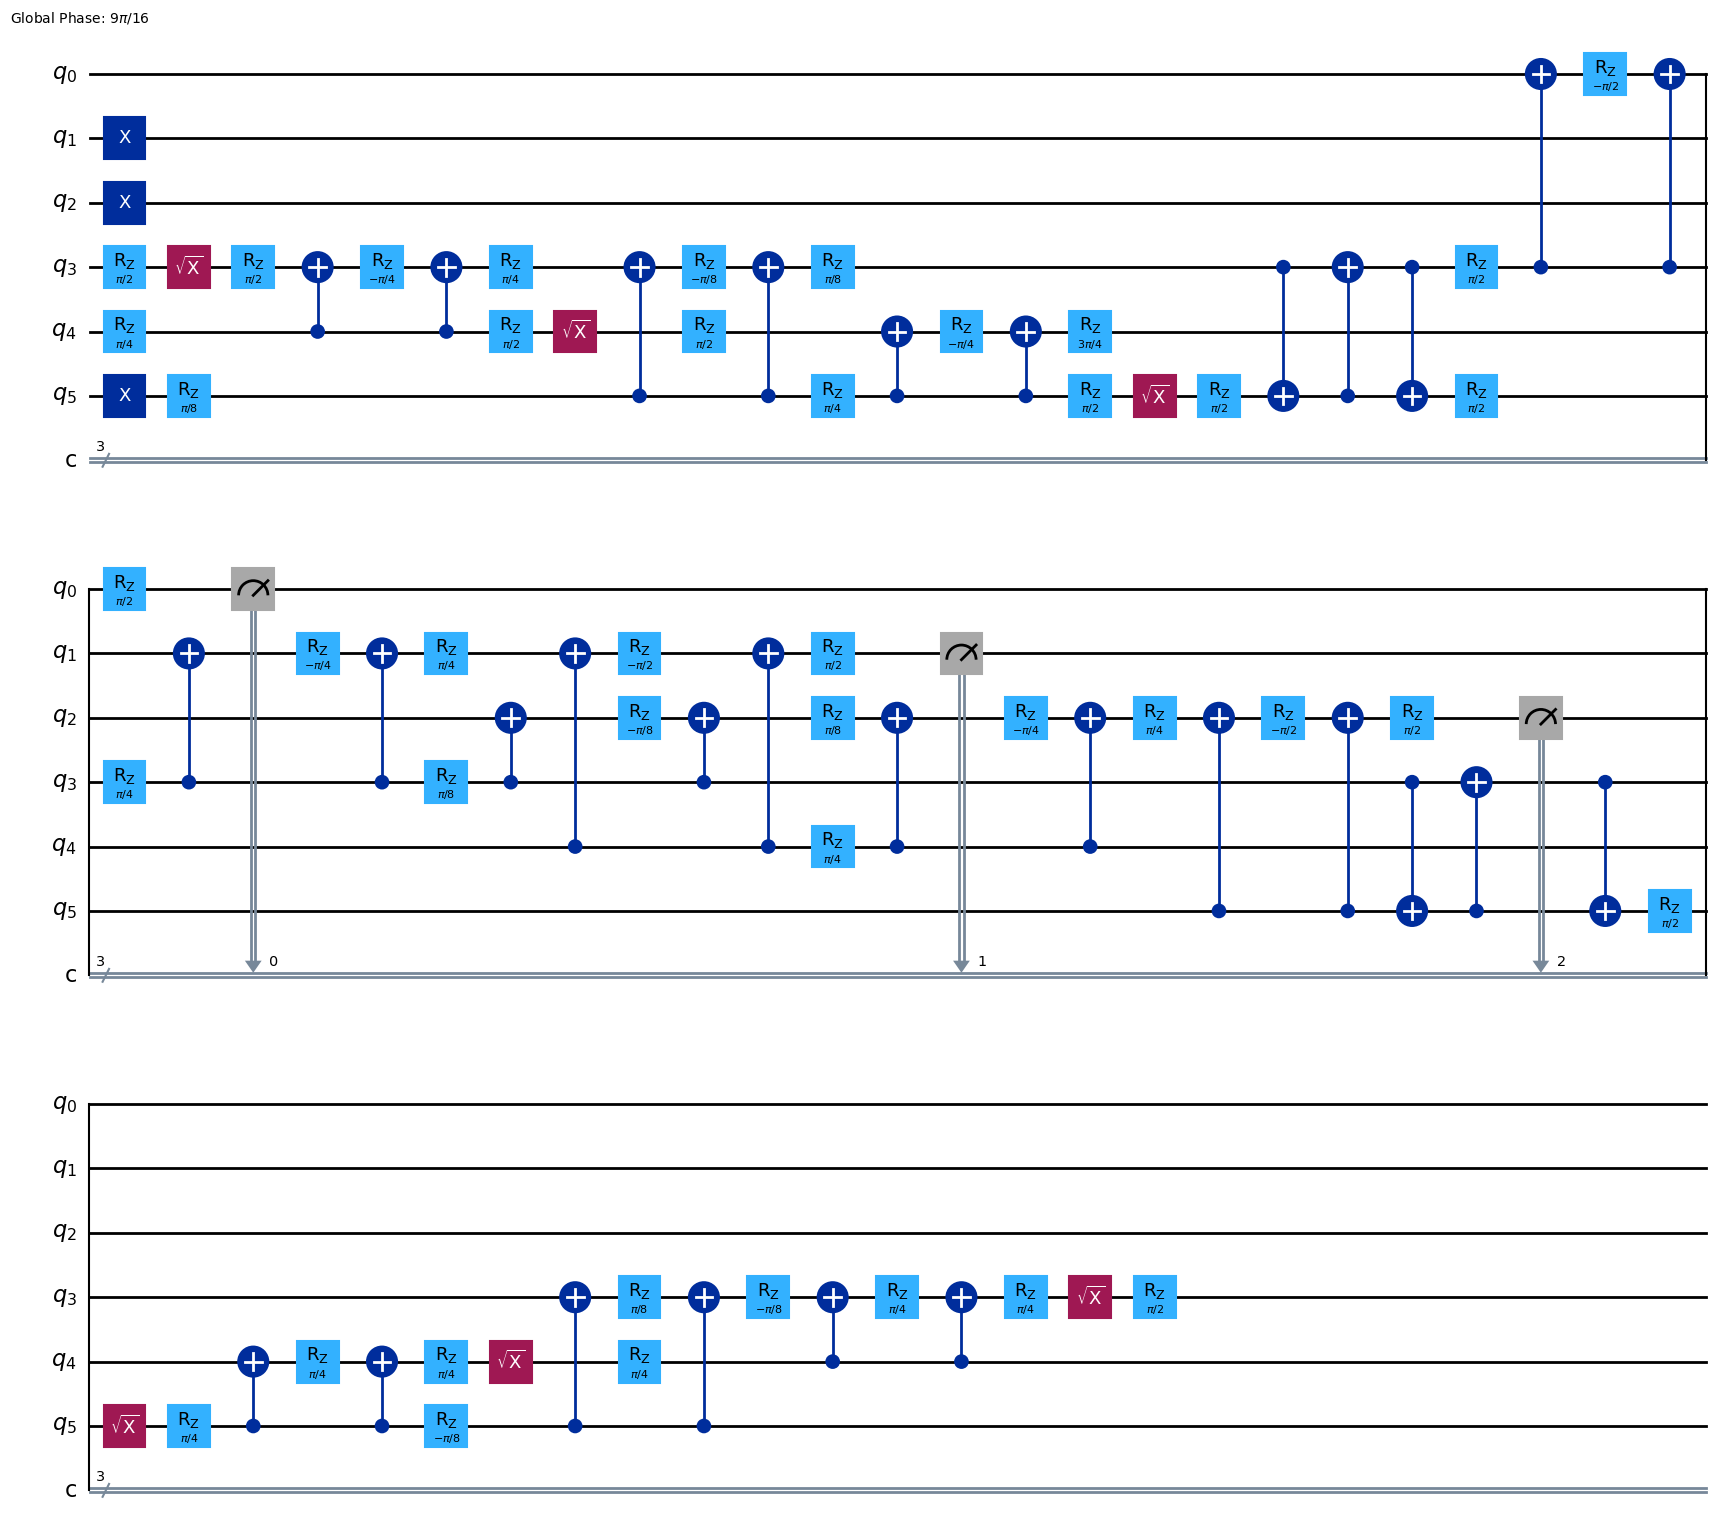

In [27]:
ideal.draw('mpl')

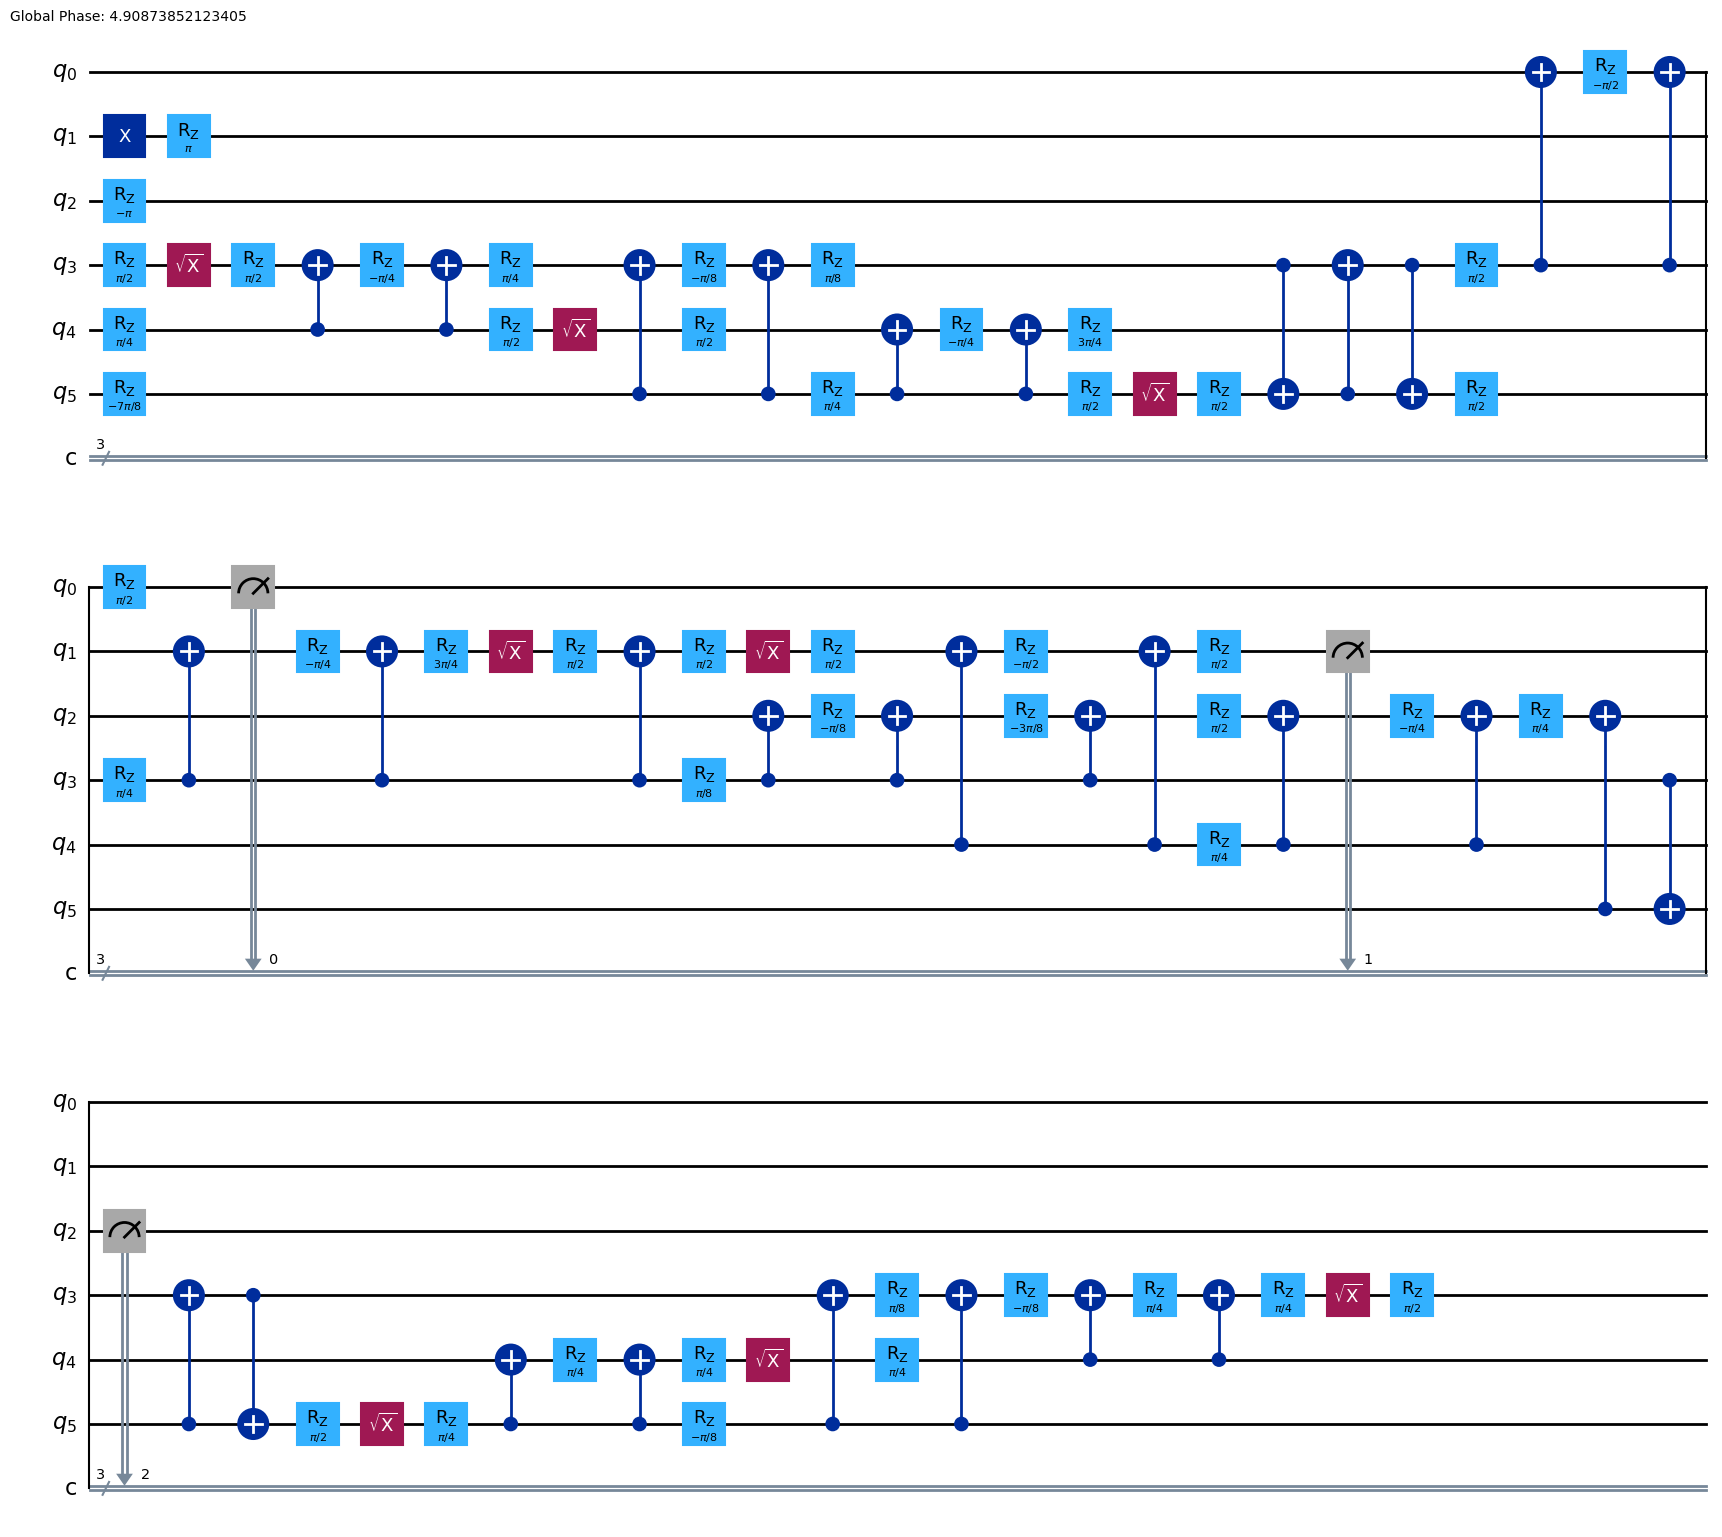

In [28]:
nonideal.draw('mpl')

In [29]:
from qiskit.providers.basic_provider import BasicSimulator

simulator = BasicSimulator()
result = simulator.run(ideal).result()
counts_ideal = result.get_counts()

In [30]:
len(list(counts_ideal.keys())[0])

3

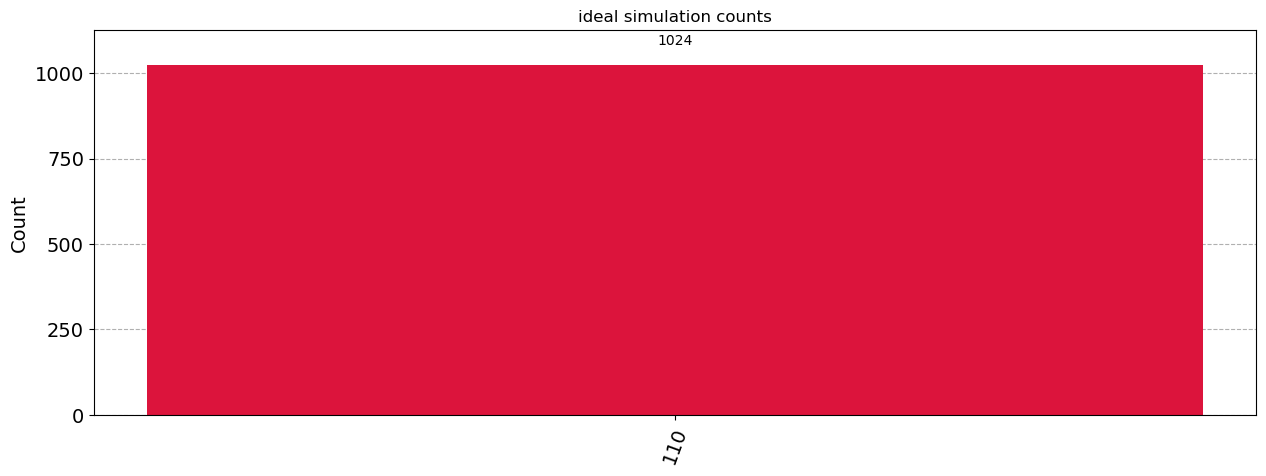

In [31]:
from qiskit.visualization import plot_histogram

plot_histogram(counts_ideal, figsize=(15,5), color='crimson', title= "ideal simulation counts")

In [32]:
from qiskit.providers.basic_provider import BasicSimulator

simulator = BasicSimulator()
result = simulator.run(nonideal).result()
counts_nonideal = result.get_counts()

simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(ideal).result()
sv_nonideal = result.get_statevector(ideal)
#sv_nonideal

In [33]:
print(f"statevector is of {int(np.log2(np.asarray(sv_nonideal).shape[0]))} qubits")

statevector is of 6 qubits


In [34]:
len(list(counts_nonideal.keys())[0])

3

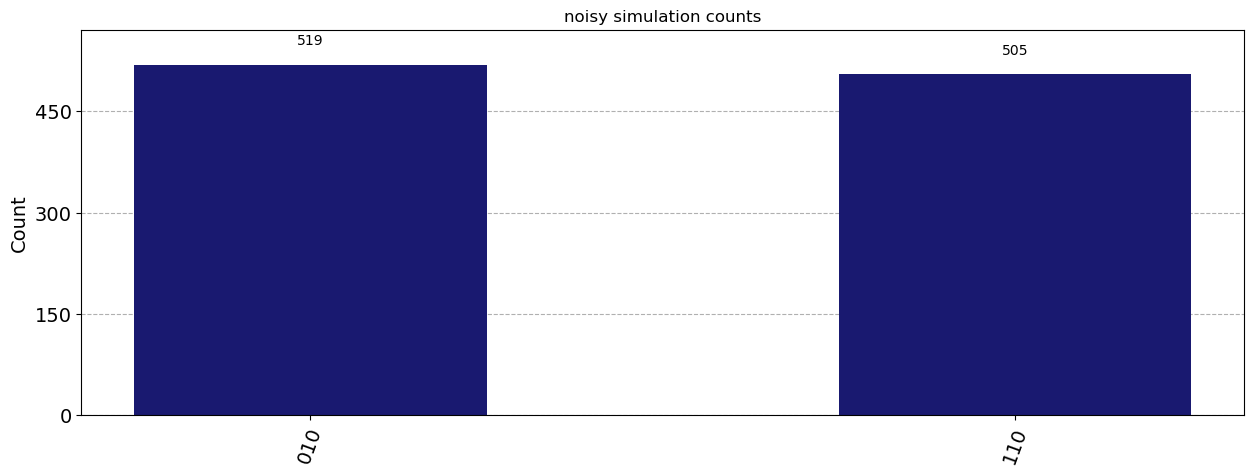

In [35]:
plot_histogram(counts_nonideal, figsize=(15,5), color='midnightblue', title= "noisy simulation counts")

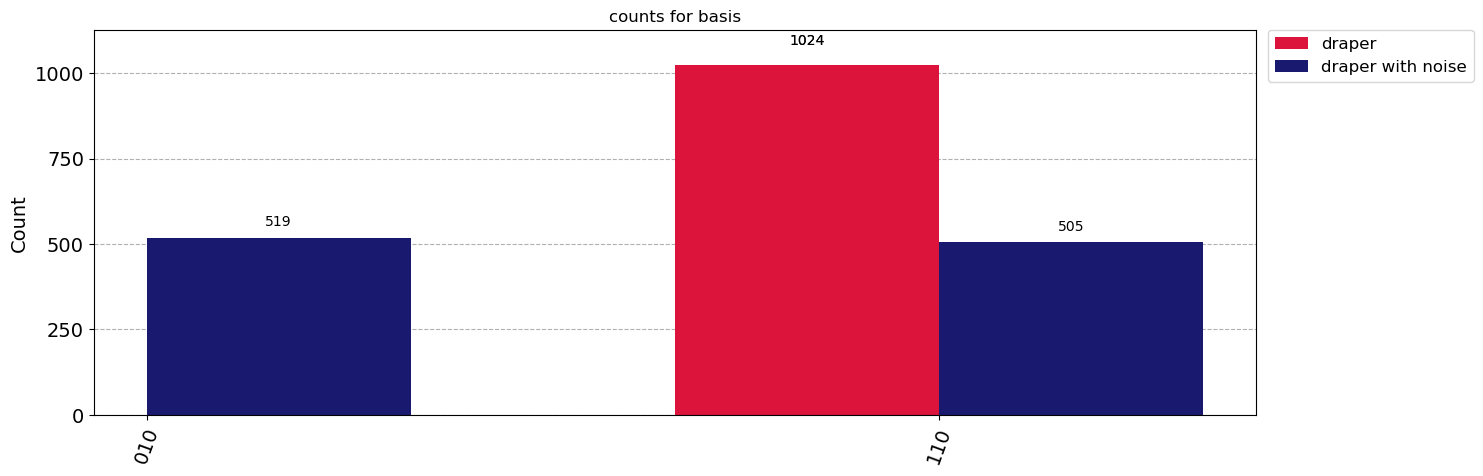

In [36]:
plot_histogram([counts_ideal, counts_nonideal], figsize=(15,5), legend = ['draper','draper with noise'], color=['crimson','midnightblue'], title= "counts for basis")

# Check using QASMsim

In [37]:
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(ideal).result()
counts_qasm_ideal = result.get_counts()
result = simulator.run(nonideal).result()
counts_qasm_nonideal = result.get_counts()

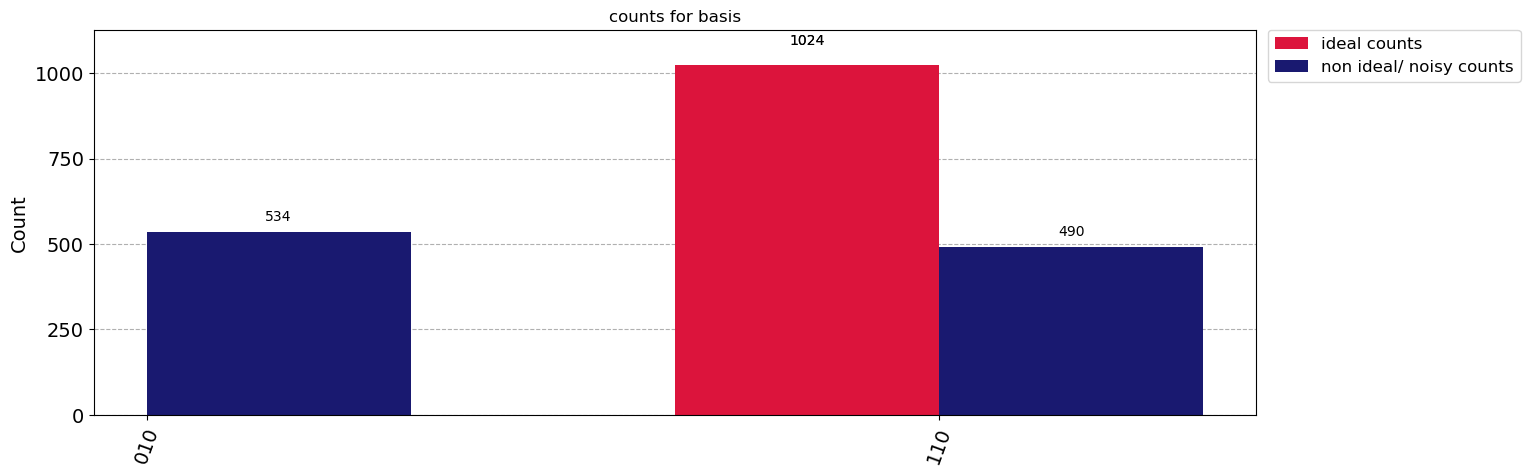

In [38]:
plot_histogram([counts_qasm_ideal,counts_qasm_nonideal], figsize=(15,5), legend = ["ideal counts", "non ideal/ noisy counts"], color=['crimson','midnightblue'], title= "counts for basis")

# Validation and accuracy check

# Simulation on real hardware

# 1. How does noise affect the results?

Sweep from 0 -> 0.5 for beta and sweep for 0.5 -> 1 for alpha. Make two lists of 5 entries and find noisy results' histograms and showing the distribution to only the output statevector. Check vslidation accuracy and show the growth rate of error

# 2. Is there a way to decrease noise?

To directly address the noise introduced by one-qubit and two-qubit gates in our QPU-transpiled circuit, we can employ both circuit optimization and error mitigation techniques that are compatible with the target QPU’s hardware capabilities. The aim is to minimize noise while preserving the statevector fidelity and ensuring accurate measurement outcomes.

#### 1. **Circuit Optimization During Transpilation**
   - **Gate Reduction**: Qiskit provides optimization levels within the transpiler that minimize the gate count by reducing redundant gate sequences and simplifying the circuit structure. For instance, adjacent gates that cancel each other (like successive Pauli-X gates) or gate pairs that simplify to a lower-cost equivalent (e.g., combining rotations) can be merged, reducing noise.
   - **Native Gate Decomposition**: By decomposing the circuit directly into the QPU’s native gate set, we bypass intermediate gates that would require further decomposition, reducing error from accumulated noise. For example, if the QPU natively supports a specific two-qubit gate, direct decomposition into this gate type is preferred to cascading gates.

#### 2. **Error Mitigation Techniques**
   - **Zero-Noise Extrapolation (ZNE)**: This method simulates low-noise conditions by scaling gate errors in the circuit (like amplifying noise slightly) and then extrapolating the results back to estimate the zero-noise outcome. Practically, this is done by running the circuit at multiple noise levels and fitting the results to “zero” noise—particularly useful for both one-qubit and two-qubit errors.
   - **Measurement Error Mitigation**: This technique specifically corrects bit-flip errors in measurements. After a series of calibration measurements on known states, a noise model can be created to correct the final outcomes. This improves the fidelity of standard basis measurements, providing outcomes more aligned with the ideal noiseless state.

#### 3. **Algorithmic Solutions for Real Hardware**
   - **Dynamical Decoupling (DD)**: This technique adds sequences of carefully timed gate pulses to refocus qubit states and counteract decoherence, extending coherence time during circuit execution. Applied at the level of the hardware, DD sequences mitigate noise for one-qubit gates but require additional care in the pulse alignment.
   - **Qubit Mapping and Routing**: Intelligent qubit mapping, where the logical qubits are placed on physically “closer” qubits in the QPU, reduces the need for two-qubit gates across long distances, directly decreasing noise from two-qubit gate errors. This becomes even more effective when combined with the transpiler’s layout optimization, ensuring that the transpilation process respects hardware-specific connectivity.

#### Conclusion: Achieving Noise Reduction in Practice
On real quantum hardware, noise reduction through optimized transpilation, error mitigation techniques, and intelligent qubit routing has shown measurable improvements. In many cases, manufacturers provide these techniques embedded in higher transpiler optimization levels. These methods preserve circuit integrity and accurate measurement outcomes, achieving a statevector and results that are robust to inherent noise.

Thus, while it is challenging to eliminate noise entirely, applying the above methods directly mitigates its impact, ensuring that the executed circuit remains faithful to its original design even under hardware-specific constraints.

# 3. How does the number of gates affect the amount of noise? 

The number of gates directly increases noise because each gate introduces a small, cumulative error upon implementation on the state's hilbert space since real-life implementation is hardware based and error during such hardware based introduction is bound to happen.

Every additional one-qubit or two-qubit gate applies an operation that is imperfect, and with more gates, these errors accumulate and scale up, causing greater deviation from the ideal state.  Two-qubit gates, in particular, are more error-prone, so circuits with many such gates experience even higher noise levels. 

Consequently, minimizing gate count and optimizing gate sequences is crucial for reducing overall noise in quantum computations.

# More examples to show the effect of noise

In [ ]:
alphas = np.linspace(0.5,1,4)
betas = np.linspace(0.5,0.75,4)
noiselevels = list(zip(alphas,betas))
noiselevels

In [ ]:
qc = quantum_sum(3, 4, 3)

noisy_qc_list = [add_noise(qc, alpha=alpha_i, beta=beta_i, n=3) for (alpha_i, beta_i) in noiselevels]
noisy_qc_list = [add_meas(qc,qcirq,3) for qcirq in noisy_qc_list]

In [ ]:
type(noisy_qc_list[0][0])

In [ ]:
noisy_qc_list = [cirq[1] for cirq in noisy_qc_list]
type(noisy_qc_list[0])

In [ ]:
sim = AerSimulator()
basis = ['cx', 'id', 'rz', 'sx', 'x']
noisy_qc_list = [transpile(cirq, sim, basis_gates=basis) for cirq in noisy_qc_list]

In [ ]:
simulator = BasicSimulator()
results = [simulator.run(cirq).result() for cirq in noisy_qc_list]
simulation_result = [result.get_counts() for result in results]

In [ ]:
len(simulation_result)

In [ ]:
plot_histogram(simulation_result, figsize=(15,5), title= "noisy simulation counts")